<a href="https://colab.research.google.com/github/shubhangshirolawala/FlashAttention/blob/main/demo_flash_attention_minimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
Make sure your runtime has a GPU enabled.
'''
# For building CUDA
!pip install Ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 10.3 MB/s eta 0:00:00


In [1]:
import os
import math
import torch
from torch.nn import functional as F
from torch.utils.cpp_extension import load_inline

# CUDA kernel implementation
cuda_source = '''
extern "C"
__global__ void flash_attention_kernel(const float* query_mat, const float* key_mat, const float* value_mat,
                           const int seq_length, const int head_dim,
                           const int num_col_tiles, const int num_row_tiles,
                           const int col_block_size, const int row_block_size,
                           const float scale_factor,
                           float* row_sum, float* row_max, float* output_mat) {

    // Thread and block indices
    int thread_id = threadIdx.x;
    int batch_idx = blockIdx.x;
    int head_idx = blockIdx.y;

    // Calculate memory offsets for this batch and head
    int matrix_offset = (batch_idx * gridDim.y * seq_length * head_dim) + (head_idx * seq_length * head_dim);
    int statistics_offset = (batch_idx * gridDim.y * seq_length) + (head_idx * seq_length);

    // Allocate shared memory for tiles
    extern __shared__ float shared_mem[];
    int block_elements = col_block_size * head_dim;

    float* query_tile = shared_mem;
    float* key_tile = &shared_mem[block_elements];
    float* value_tile = &shared_mem[block_elements * 2];
    float* attention_scores = &shared_mem[block_elements * 3];

    // Iterate over column tiles (K, V)
    for (int col_tile_idx = 0; col_tile_idx < num_col_tiles; col_tile_idx++) {

        // Load key and value tiles into shared memory
        for (int dim_idx = 0; dim_idx < head_dim; dim_idx++) {
            int key_idx = matrix_offset + (block_elements * col_tile_idx) + (thread_id * head_dim) + dim_idx;
            key_tile[(thread_id * head_dim) + dim_idx] = key_mat[key_idx];
            value_tile[(thread_id * head_dim) + dim_idx] = value_mat[key_idx];
        }
        __syncthreads();

        // Iterate over row tiles (Q)
        for (int row_tile_idx = 0; row_tile_idx < num_row_tiles; row_tile_idx++) {

            // Load query tile and statistics into registers
            for (int dim_idx = 0; dim_idx < head_dim; dim_idx++) {
                int query_idx = matrix_offset + (block_elements * row_tile_idx) + (thread_id * head_dim) + dim_idx;
                query_tile[(thread_id * head_dim) + dim_idx] = query_mat[query_idx];
            }

            int stat_idx = statistics_offset + (row_block_size * row_tile_idx) + thread_id;
            float prev_max = row_max[stat_idx];
            float prev_sum = row_sum[stat_idx];

            // Compute attention scores: S = Q @ K^T, and find row maximum
            float current_max = -INFINITY;
            for (int col_elem = 0; col_elem < col_block_size; col_elem++) {
                float dot_product = 0;
                for (int dim_idx = 0; dim_idx < head_dim; dim_idx++) {
                    dot_product += query_tile[(thread_id * head_dim) + dim_idx] *
                                  key_tile[(col_elem * head_dim) + dim_idx];
                }
                dot_product *= scale_factor;
                attention_scores[(col_block_size * thread_id) + col_elem] = dot_product;

                current_max = fmaxf(current_max, dot_product);
            }

            // Apply softmax: exp(S - max) and compute row sum
            float current_sum = 0;
            for (int col_elem = 0; col_elem < col_block_size; col_elem++) {
                float exp_score = __expf(attention_scores[(col_block_size * thread_id) + col_elem] - current_max);
                attention_scores[(col_block_size * thread_id) + col_elem] = exp_score;
                current_sum += exp_score;
            }

            // Update statistics with numerically stable formulas
            float updated_max = fmaxf(prev_max, current_max);
            float updated_sum = (__expf(prev_max - updated_max) * prev_sum) +
                               (__expf(current_max - updated_max) * current_sum);

            // Compute and write output: O = softmax(S) @ V
            for (int dim_idx = 0; dim_idx < head_dim; dim_idx++) {
                float weighted_value = 0;
                for (int col_elem = 0; col_elem < col_block_size; col_elem++) {
                    weighted_value += attention_scores[(col_block_size * thread_id) + col_elem] *
                                     value_tile[(col_elem * head_dim) + dim_idx];
                }

                int output_idx = matrix_offset + (block_elements * row_tile_idx) + (thread_id * head_dim) + dim_idx;
                float prev_output = output_mat[output_idx];

                output_mat[output_idx] = (1.0f / updated_sum) *
                    ((prev_sum * __expf(prev_max - updated_max) * prev_output) +
                     (__expf(current_max - updated_max) * weighted_value));
            }

            // Update statistics in global memory
            row_max[stat_idx] = updated_max;
            row_sum[stat_idx] = updated_sum;
        }
        __syncthreads();
    }
}

torch::Tensor forward(torch::Tensor Q, torch::Tensor K, torch::Tensor V) {
    // Define tile sizes
    const int TILE_SIZE = 32;
    const int col_block_size = TILE_SIZE;
    const int row_block_size = TILE_SIZE;

    // Extract tensor dimensions
    const int batch_size = Q.size(0);
    const int num_heads = Q.size(1);
    const int seq_length = Q.size(2);
    const int head_dim = Q.size(3);

    // Calculate number of tiles needed
    const int num_col_tiles = (seq_length + col_block_size - 1) / col_block_size;
    const int num_row_tiles = (seq_length + row_block_size - 1) / row_block_size;
    const float scale_factor = 1.0f / sqrtf(static_cast<float>(head_dim));

    // Allocate output and statistics tensors
    auto output_mat = torch::zeros_like(Q);
    auto row_sum = torch::zeros({batch_size, num_heads, seq_length});
    auto row_max = torch::full({batch_size, num_heads, seq_length}, -INFINITY);

    torch::Device device(torch::kCUDA);
    row_sum = row_sum.to(device);
    row_max = row_max.to(device);

    // Calculate shared memory requirements
    const int shared_mem_size = (3 * col_block_size * head_dim * sizeof(float)) +
                                (col_block_size * row_block_size * sizeof(float));

    int max_shared_mem;
    cudaDeviceGetAttribute(&max_shared_mem, cudaDevAttrMaxSharedMemoryPerBlock, 0);
    printf("Max shared memory: %d bytes, Requested: %d bytes\\n", max_shared_mem, shared_mem_size);

    // Launch kernel
    dim3 grid_config(batch_size, num_heads);
    dim3 block_config(col_block_size);

    flash_attention_kernel<<<grid_config, block_config, shared_mem_size>>>(
        Q.data_ptr<float>(), K.data_ptr<float>(), V.data_ptr<float>(),
        seq_length, head_dim, num_col_tiles, num_row_tiles,
        col_block_size, row_block_size, scale_factor,
        row_sum.data_ptr<float>(), row_max.data_ptr<float>(), output_mat.data_ptr<float>()
    );

    return output_mat;
}
'''

# C++ interface
cpp_source = 'torch::Tensor forward(torch::Tensor Q, torch::Tensor K, torch::Tensor V);'

# Build directory setup
compilation_dir = 'cuda'
if not os.path.exists(compilation_dir):
    os.makedirs(compilation_dir)

# Compile and load the extension
minimal_attn = load_inline(
    name='minimal_attn',
    cpp_sources=cpp_source,
    cuda_sources=cuda_source,
    functions=['forward'],
    with_cuda=True,
    extra_cuda_cflags=['-O2'],
    build_directory=f'./{compilation_dir}'
)

W1031 03:16:55.374000 3532 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1031 03:16:55.374000 3532 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


In [3]:
batch_size = 1
n_head = 1
seq_len = 256
head_embd = 4

q = torch.randn(batch_size, n_head, seq_len, head_embd).cuda()
k = torch.randn(batch_size, n_head, seq_len, head_embd).cuda()
v = torch.randn(batch_size, n_head, seq_len, head_embd).cuda()

print('=== profiling manual attention ===')

# Our minimal flash attention needs to be faster than this.
def manual_attn(q, k, v):
    att = (q @ k.transpose(-2, -1) * (1.0 / math.sqrt(k.size(-1))))
    att = F.softmax(att, dim=-1)
    y = att @ v
    return y

with torch.autograd.profiler.profile(use_cuda=True) as prof:
    manual_result = manual_attn(q, k, v)


print(prof.key_averages().table(sort_by='cuda_time_total', row_limit=10))

print('=== profiling minimal flash attention === ')

with torch.autograd.profiler.profile(use_cuda=True) as prof:
    minimal_result = minimal_attn.forward(q, k, v)
print(prof.key_averages().table(sort_by='cuda_time_total', row_limit=10))

print('attn values sanity check:', torch.allclose(minimal_result, manual_result, rtol=0, atol=1e-02))
# print(minimal_result)
# print(manual_result)

=== profiling manual attention ===


/tmp/ipython-input-122505292.py:19: FutureWarning: The attribute `use_cuda` will be deprecated soon, please use ``use_device = 'cuda'`` instead.
  with torch.autograd.profiler.profile(use_cuda=True) as prof:


-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                     aten::matmul         2.69%       5.558ms        59.13%     122.031ms      61.016ms       5.551ms         2.69%     122.040ms      61.020ms             2  
                                        aten::bmm        30.37%      62.680ms        53.65%     110.723ms      55.361ms     110.756ms        53.67%     110.756ms      55.378ms             2  
                                    ate

/tmp/ipython-input-122505292.py:27: FutureWarning: The attribute `use_cuda` will be deprecated soon, please use ``use_device = 'cuda'`` instead.
  with torch.autograd.profiler.profile(use_cuda=True) as prof:


attn values sanity check: True


Benchmarking sequence length: 64
  Manual: 0.625 ms, Flash: 0.467 ms
Benchmarking sequence length: 128


/tmp/ipython-input-2668896390.py:51: FutureWarning: The attribute `use_cuda` will be deprecated soon, please use ``use_device = 'cuda'`` instead.
  with torch.autograd.profiler.profile(use_cuda=True) as prof:
/tmp/ipython-input-2668896390.py:55: FutureWarning: `cuda_time_total` is deprecated. Use `device_time_total` instead.
  cuda_time = sum([evt.cuda_time_total for evt in prof.function_events])
/tmp/ipython-input-2668896390.py:64: FutureWarning: The attribute `use_cuda` will be deprecated soon, please use ``use_device = 'cuda'`` instead.
  with torch.autograd.profiler.profile(use_cuda=True) as prof:
/tmp/ipython-input-2668896390.py:68: FutureWarning: `cuda_time_total` is deprecated. Use `device_time_total` instead.
  cuda_time = sum([evt.cuda_time_total for evt in prof.function_events])


  Manual: 0.611 ms, Flash: 0.496 ms
Benchmarking sequence length: 256
  Manual: 0.645 ms, Flash: 0.465 ms
Benchmarking sequence length: 512
  Manual: 0.725 ms, Flash: 0.478 ms
Benchmarking sequence length: 1024
  Manual: 0.722 ms, Flash: 0.473 ms
Benchmarking sequence length: 2048
  Manual: 1.246 ms, Flash: 0.488 ms
Benchmarking sequence length: 4096
  Manual: 3.744 ms, Flash: 0.688 ms
Benchmarking sequence length: 8192
  Manual: 12.664 ms, Flash: 0.841 ms


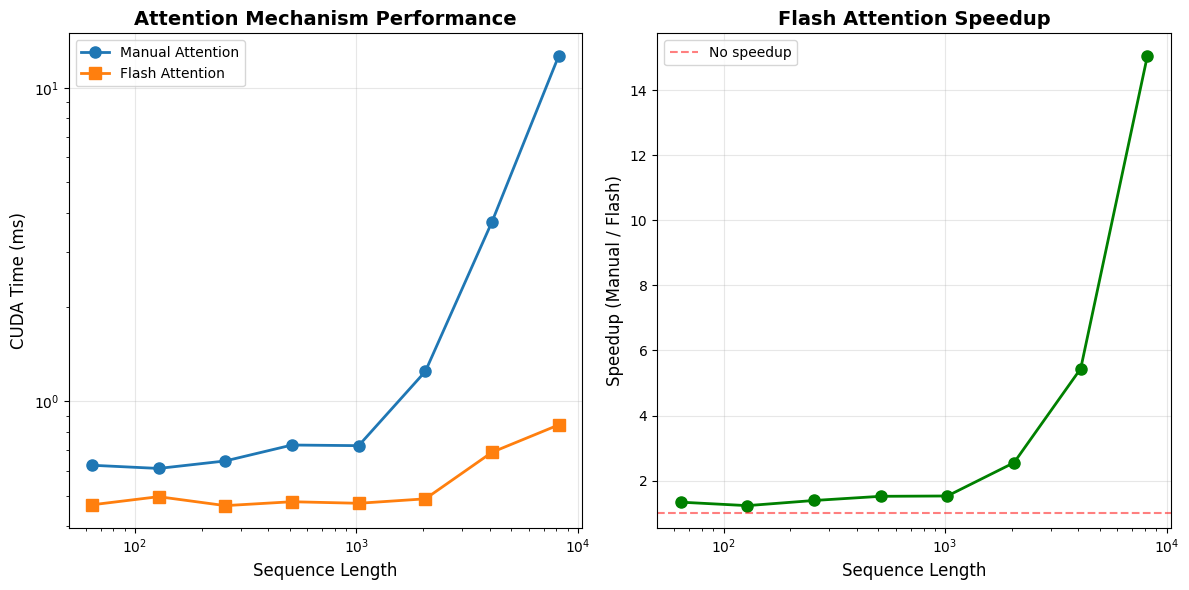


=== Benchmark Summary ===
Seq Len    Manual (ms)     Flash (ms)      Speedup   
--------------------------------------------------
64         0.625           0.467           1.34      x
128        0.611           0.496           1.23      x
256        0.645           0.465           1.39      x
512        0.725           0.478           1.52      x
1024       0.722           0.473           1.53      x
2048       1.246           0.488           2.55      x
4096       3.744           0.688           5.44      x
8192       12.664          0.841           15.06     x


In [ ]:
import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np

def benchmark_attention(seq_lengths, batch_size=1, n_head=1, head_embd=4, num_warmup=3, num_iterations=10):
    """
    Benchmark manual and flash attention across different sequence lengths.

    Args:
        seq_lengths: List of sequence lengths to test
        batch_size: Batch size for attention
        n_head: Number of attention heads
        head_embd: Embedding dimension per head
        num_warmup: Number of warmup iterations
        num_iterations: Number of iterations to average over

    Returns:
        manual_times: List of average CUDA times for manual attention
        flash_times: List of average CUDA times for flash attention
    """

    def manual_attn(q, k, v):
        att = (q @ k.transpose(-2, -1) * (1.0 / math.sqrt(k.size(-1))))
        att = F.softmax(att, dim=-1)
        y = att @ v
        return y

    manual_times = []
    flash_times = []

    for seq_len in seq_lengths:
        print(f"Benchmarking sequence length: {seq_len}")

        # Generate random tensors
        q = torch.randn(batch_size, n_head, seq_len, head_embd).cuda()
        k = torch.randn(batch_size, n_head, seq_len, head_embd).cuda()
        v = torch.randn(batch_size, n_head, seq_len, head_embd).cuda()

        # Warmup runs
        for _ in range(num_warmup):
            _ = manual_attn(q, k, v)
            _ = minimal_attn.forward(q, k, v)

        torch.cuda.synchronize()

        # Benchmark manual attention
        manual_cuda_times = []
        for _ in range(num_iterations):
            with torch.autograd.profiler.profile(use_cuda=True) as prof:
                _ = manual_attn(q, k, v)

            # Extract CUDA time
            cuda_time = sum([evt.cuda_time_total for evt in prof.function_events])
            manual_cuda_times.append(cuda_time)

        avg_manual_time = np.mean(manual_cuda_times)
        manual_times.append(avg_manual_time / 1000)  # Convert to milliseconds

        # Benchmark flash attention
        flash_cuda_times = []
        for _ in range(num_iterations):
            with torch.autograd.profiler.profile(use_cuda=True) as prof:
                _ = minimal_attn.forward(q, k, v)

            # Extract CUDA time
            cuda_time = sum([evt.cuda_time_total for evt in prof.function_events])
            flash_cuda_times.append(cuda_time)

        avg_flash_time = np.mean(flash_cuda_times)
        flash_times.append(avg_flash_time / 1000)  # Convert to milliseconds

        print(f"  Manual: {avg_manual_time/1000:.3f} ms, Flash: {avg_flash_time/1000:.3f} ms")

    return manual_times, flash_times


def plot_attention_benchmark(seq_lengths, manual_times, flash_times):
    """
    Plot the benchmark results.

    Args:
        seq_lengths: List of sequence lengths
        manual_times: List of manual attention times (ms)
        flash_times: List of flash attention times (ms)
    """
    plt.figure(figsize=(12, 6))

    # Plot 1: Absolute times
    plt.subplot(1, 2, 1)
    plt.plot(seq_lengths, manual_times, 'o-', label='Manual Attention', linewidth=2, markersize=8)
    plt.plot(seq_lengths, flash_times, 's-', label='Flash Attention', linewidth=2, markersize=8)
    plt.xlabel('Sequence Length', fontsize=12)
    plt.ylabel('CUDA Time (ms)', fontsize=12)
    plt.title('Attention Mechanism Performance', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.xscale('log')

    # Plot 2: Speedup
    plt.subplot(1, 2, 2)
    speedup = [m / f for m, f in zip(manual_times, flash_times)]
    plt.plot(seq_lengths, speedup, 'o-', color='green', linewidth=2, markersize=8)
    plt.axhline(y=1, color='r', linestyle='--', label='No speedup', alpha=0.5)
    plt.xlabel('Sequence Length', fontsize=12)
    plt.ylabel('Speedup (Manual / Flash)', fontsize=12)
    plt.title('Flash Attention Speedup', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xscale('log')

    plt.tight_layout()
    plt.show()

    # Print summary
    print("\n=== Benchmark Summary ===")
    print(f"{'Seq Len':<10} {'Manual (ms)':<15} {'Flash (ms)':<15} {'Speedup':<10}")
    print("-" * 50)
    for seq_len, manual, flash in zip(seq_lengths, manual_times, flash_times):
        speedup = manual / flash
        print(f"{seq_len:<10} {manual:<15.3f} {flash:<15.3f} {speedup:<10.2f}x")


# Example usage:
seq_lengths = [64, 128, 256, 512, 1024, 2048, 4096, 8192]  # Adjust based on your GPU memory

manual_times, flash_times = benchmark_attention(
    seq_lengths=seq_lengths,
    batch_size=1,
    n_head=1,
    head_embd=4,
    num_warmup=3,
    num_iterations=10
)

plot_attention_benchmark(seq_lengths, manual_times, flash_times)

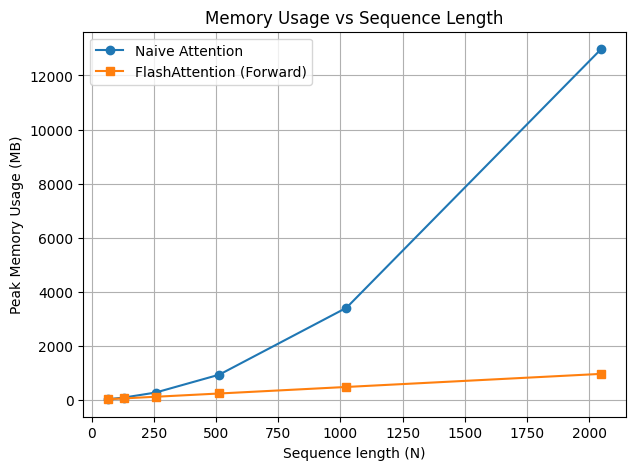

In [4]:
import torch
import matplotlib.pyplot as plt

lens = [64, 128, 256, 512, 1024, 2048]
mem_manual, mem_flash = [], []

for N in lens:
    q = torch.randn(32, 12, N, 64, device="cuda")
    k = torch.randn(32, 12, N, 64, device="cuda")
    v = torch.randn(32, 12, N, 64, device="cuda")

    # PyTorch naive attention
    torch.cuda.reset_peak_memory_stats()
    _ = manual_attn(q, k, v)
    torch.cuda.synchronize()
    mem_manual.append(torch.cuda.max_memory_allocated() / (1024 ** 2))  # in MB

    # FlashAttention forward
    torch.cuda.reset_peak_memory_stats()
    _ = minimal_attn.forward(q, k, v)
    torch.cuda.synchronize()
    mem_flash.append(torch.cuda.max_memory_allocated() / (1024 ** 2))

plt.figure(figsize=(7,5))
plt.plot(lens, mem_manual, 'o-', label='Naive Attention')
plt.plot(lens, mem_flash, 's-', label='FlashAttention (Forward)')
plt.xlabel("Sequence length (N)")
plt.ylabel("Peak Memory Usage (MB)")
plt.title("Memory Usage vs Sequence Length")
plt.legend()
plt.grid(True)
plt.show()


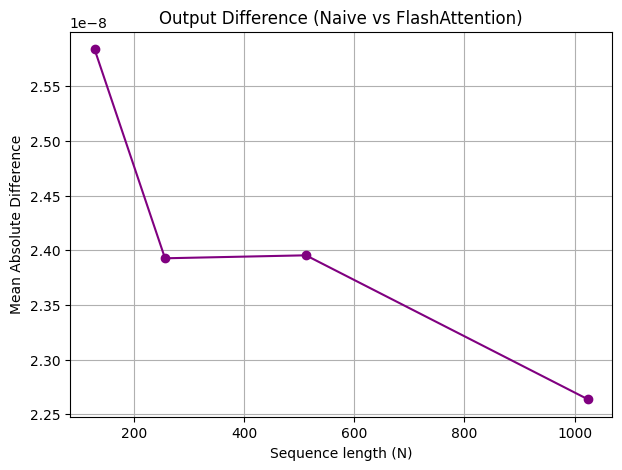

In [5]:
import torch, math
import matplotlib.pyplot as plt

lens = [128, 256, 512, 1024]
diffs = []

for N in lens:
    q = torch.randn(1, 2, N, 64, device="cuda")
    k = torch.randn(1, 2, N, 64, device="cuda")
    v = torch.randn(1, 2, N, 64, device="cuda")

    out_manual = manual_attn(q, k, v)
    out_flash = minimal_attn.forward(q, k, v)
    diff = torch.abs(out_manual - out_flash).mean().item()
    diffs.append(diff)

plt.figure(figsize=(7,5))
plt.plot(lens, diffs, 'o-', color='purple')
plt.xlabel("Sequence length (N)")
plt.ylabel("Mean Absolute Difference")
plt.title("Output Difference (Naive vs FlashAttention)")
plt.grid(True)
plt.show()
